<a href="https://colab.research.google.com/github/jhashekhar/generative-models/blob/master/gans/mnist-gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Generative Adversarial Networks**

New framework for estimating generative models via an adversarial process, in which we simutaneously train two models: a generative model G that captures the data distribution, and a discriminative model D that estimates the probability that a sample came from the training data rather than G.

The training procedure for G is to maximize the probability of D making a mistake. 

In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision import transforms

In [0]:
os.makedirs('images-gan1', exist_ok=True)

In [0]:
BATCH_SIZE = 64
ngpu = 1
dataset = torchvision.datasets.MNIST('./data', 
                                     download=True,
                                     transform = transforms.Compose([
                                         transforms.ToTensor(), 
                                         transforms.Normalize((0.5,), (0.5,))
                                     ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [0]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [0]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.h1 = nn.Linear(64, 128)
    self.h2 = nn.Linear(128, 512)
    self.h3 = nn.Linear(512, 1024)
    self.h4 = nn.Linear(1024, 28*28)
    self.relu = nn.LeakyReLU(0.2)
    self.tanh = nn.Tanh()
    
  def forward(self, x):
    x = self.relu(self.h1(x))
    x = self.relu(self.h2(x))
    x = self.relu(self.h3(x))
    x = self.tanh(self.h4(x))
    return x

In [0]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.h1 = nn.Linear(28*28, 512)
    self.h2 = nn.Linear(512, 256)
    self.h3 = nn.Linear(256, 1)
    self.sigmoid = nn.Sigmoid()
    self.relu = nn.LeakyReLU(0.2)
    
  def forward(self, x):
    x = self.relu(self.h1(x))
    x = self.relu(self.h2(x))
    x = self.sigmoid(self.h3(x))
    return x

In [0]:
generator = Generator(ngpu).to(device)
discriminator = Discriminator(ngpu).to(device)

In [0]:
criterion = torch.nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999)) 
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [133]:
Tensor = torch.cuda.FloatTensor
# ============
# Training
# ============
num_epochs = 100
latent_dim = 64
sample_interval = 400
samples = []
sample_size = 24
fixed_z = np.random.normal(0, 1, size=(sample_size, latent_dim))
fixed_z = torch.from_numpy(fixed_z).float().to(device)

# Training mode
discriminator.train()
generator.train()

for epoch in range(num_epochs):
  
  for i, data in enumerate(dataloader):
    imgs, _ = data
 
    # Ground truths
    valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
    fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
    
    real_imgs = Variable(imgs.type(Tensor))
    real_imgs = real_imgs.view(-1, 784)
   
    # ================
    # Train Generator
    # ================
    optimizer_G.zero_grad()
    
    # Sample noise as generator input
    z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
    
    # Generate a batch of images
    gen_imgs = generator(z)
    
    # Calculate Loss
    g_loss = criterion(discriminator(gen_imgs), valid)
    g_loss.backward()
    optimizer_G.step()
    
    # ===================
    # Train Discriminator
    # ===================
    optimizer_D.zero_grad()
    
    # Train with real image
    real_loss = criterion(discriminator(real_imgs), valid)
    
    # Train with fake image
    fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_D.step()
    
    batches_done = epoch * len(dataloader) + i
    if batches_done % sample_interval == 0:
      print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch+1, num_epochs, i, len(dataloader), d_loss.item(), g_loss.item()))
      
   
  generator.eval() # eval mode for generating samples
  sample_z = generator(fixed_z)
  samples.append(sample_z)
  save_image(to_img(sample_z.data[:24]), 'images-gan1/%d.png' % batches_done, nrow=6, normalize=True)
  generator.train()
  

[Epoch 1/100] [Batch 0/938] [D loss: 0.673317] [G loss: 1.114533]
[Epoch 1/100] [Batch 400/938] [D loss: 0.319829] [G loss: 1.850184]
[Epoch 1/100] [Batch 800/938] [D loss: 0.425996] [G loss: 1.592158]
[Epoch 2/100] [Batch 262/938] [D loss: 0.440708] [G loss: 2.058230]
[Epoch 2/100] [Batch 662/938] [D loss: 0.328581] [G loss: 1.730249]
[Epoch 3/100] [Batch 124/938] [D loss: 0.648256] [G loss: 1.075850]
[Epoch 3/100] [Batch 524/938] [D loss: 0.376332] [G loss: 1.959702]
[Epoch 3/100] [Batch 924/938] [D loss: 0.796608] [G loss: 1.449192]
[Epoch 4/100] [Batch 386/938] [D loss: 0.453196] [G loss: 1.968834]
[Epoch 4/100] [Batch 786/938] [D loss: 0.765518] [G loss: 1.779266]
[Epoch 5/100] [Batch 248/938] [D loss: 1.035017] [G loss: 0.642479]
[Epoch 5/100] [Batch 648/938] [D loss: 0.837807] [G loss: 1.837080]
[Epoch 6/100] [Batch 110/938] [D loss: 0.627547] [G loss: 1.755863]
[Epoch 6/100] [Batch 510/938] [D loss: 0.763461] [G loss: 2.841983]
[Epoch 6/100] [Batch 910/938] [D loss: 1.083092] [

In [0]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.cpu().detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

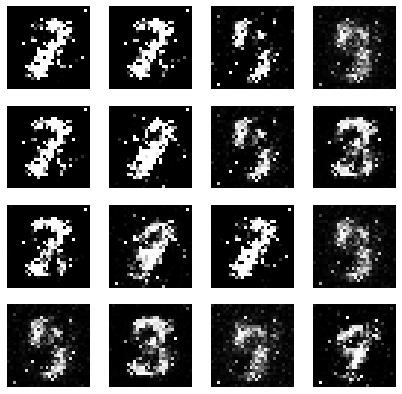

In [178]:
# Generated sample at Epoch = 0
view_samples(0, samples)

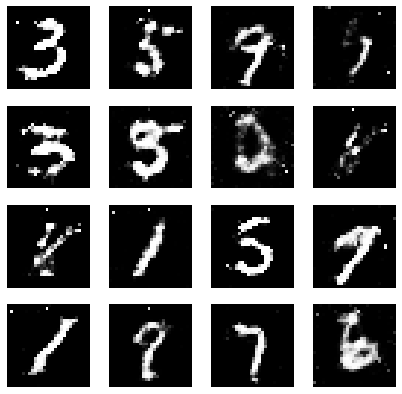

In [181]:
# Generated sample at Epoch = 21
view_samples(20, samples)

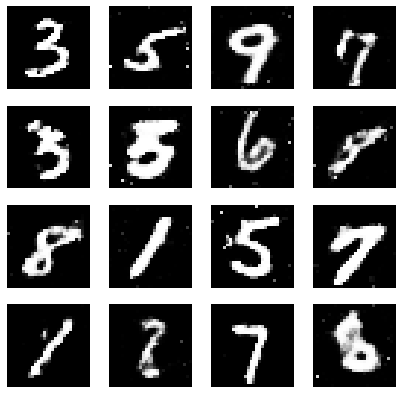

In [180]:
# Generated sample at Epoch = 50
view_samples(49, samples)

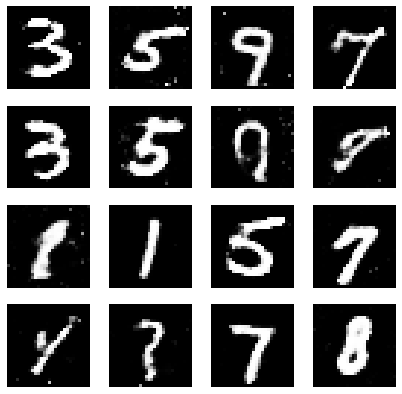

In [179]:
# Generated sample at Epoch = 100
view_samples(99, samples)

In [158]:
samples[99][0].cpu().detach().numpy().shape

(784,)